In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input

In [3]:
import data_processing as dp
(X_train, y_train), (X_val, y_val), (X_test, y_test), reverse_map = dp.load_asl_alphabet_dataset1(
    img_size=64,
    color_mode='grayscale'
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (60900, 64, 64, 1), Validation shape: (17400, 64, 64, 1), Test shape: (8700, 64, 64, 1)


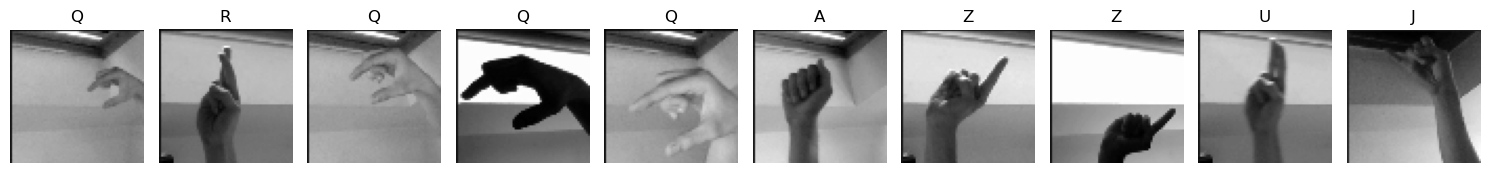

In [4]:

def show_samples(X, y, reverse_map, num_samples):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i].reshape(X.shape[1], X.shape[2]), cmap='gray')
        plt.title(reverse_map[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_samples(X_train, y_train, reverse_map, num_samples = 10)

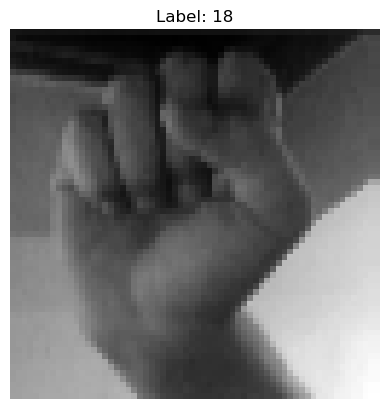

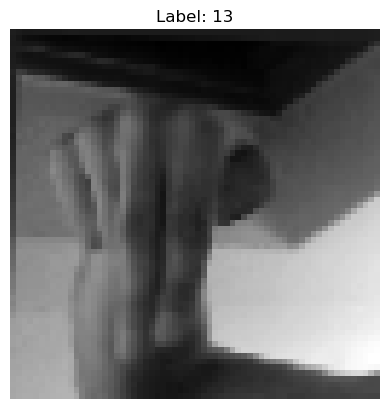

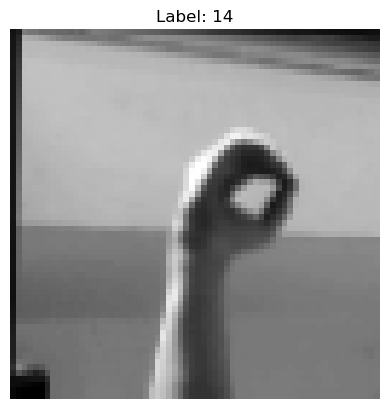

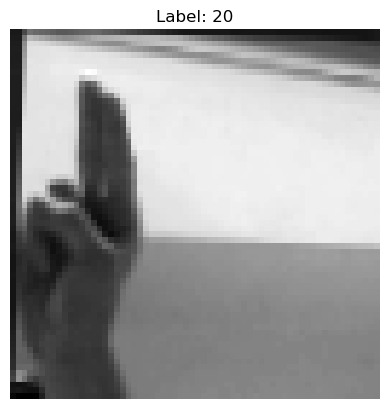

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.02
)

# Visualize a few augmented samples
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, shuffle=True):
    for i in range(4):
        img = X_batch[i].squeeze()  # shape: (64,64) or (64,64,1)
        
        # Since generator already scaled to 0-1, multiply by 255 for display
        img_display = (img * 255).astype(np.uint8)
        
        # Show grayscale image
        plt.imshow(img_display, cmap='gray')
        plt.title(f"Label: {y_batch[i]}")
        plt.axis('off')
        plt.show()
    break

In [6]:
input_shape = (64, 64, 1)
num_classes = 29

def build_cnn():
    model = Sequential()
    model.add(Input(shape=input_shape))

    # 1st conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.15))

    # 2nd conv block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.15))

    # 3rd conv block
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn()

model.summary()

2025-07-28 21:50:37.825697: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-28 21:50:37.825894: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-28 21:50:37.825927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-28 21:50:37.825975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-28 21:50:37.826025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,477 (1.22 MB)

 Trainable params: 320,157 (1.22 MB)

 Non-trainable params: 320 (1.25 KB)

In [7]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("./model/cnn_1.keras", save_best_only=True)

# Train using the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-07-28 21:50:38.775633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-28 21:50:38.781452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1903/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1318 - loss: 3.0509

2025-07-28 21:51:53.802623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.1318 - loss: 3.0505 - val_accuracy: 0.4772 - val_loss: 1.6500
Epoch 2/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.4274 - loss: 1.7820 - val_accuracy: 0.6949 - val_loss: 0.9100
Epoch 3/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - accuracy: 0.6282 - loss: 1.1039 - val_accuracy: 0.8928 - val_loss: 0.3797
Epoch 4/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.7341 - loss: 0.7603 - val_accuracy: 0.9341 - val_loss: 0.2357
Epoch 5/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.7974 - loss: 0.5846 - val_accuracy: 0.9505 - val_loss: 0.1674
Epoch 6/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.8320 - loss: 0.4793 - val_accuracy: 0.9270 - val_loss: 0.2137
Epoch 7/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.8638 - loss: 0.3927 - val_accuracy: 0.9736 - val_loss: 0.0919
Epoch 8/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - accuracy: 0.8793 - loss: 0.34

In [8]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"CNN 1 Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9859 - loss: 0.0523
CNN 1 Validation Accuracy: 0.9853, Loss: 0.0533


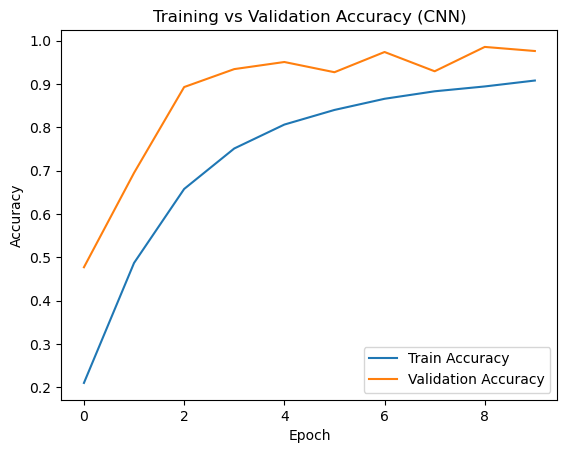

In [9]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy (CNN)")
plt.show()

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"CNN 1 Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9859 - loss: 0.0498
CNN 1 Test Accuracy: 0.9854, Loss: 0.0527


2025-07-28 22:11:04.200602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


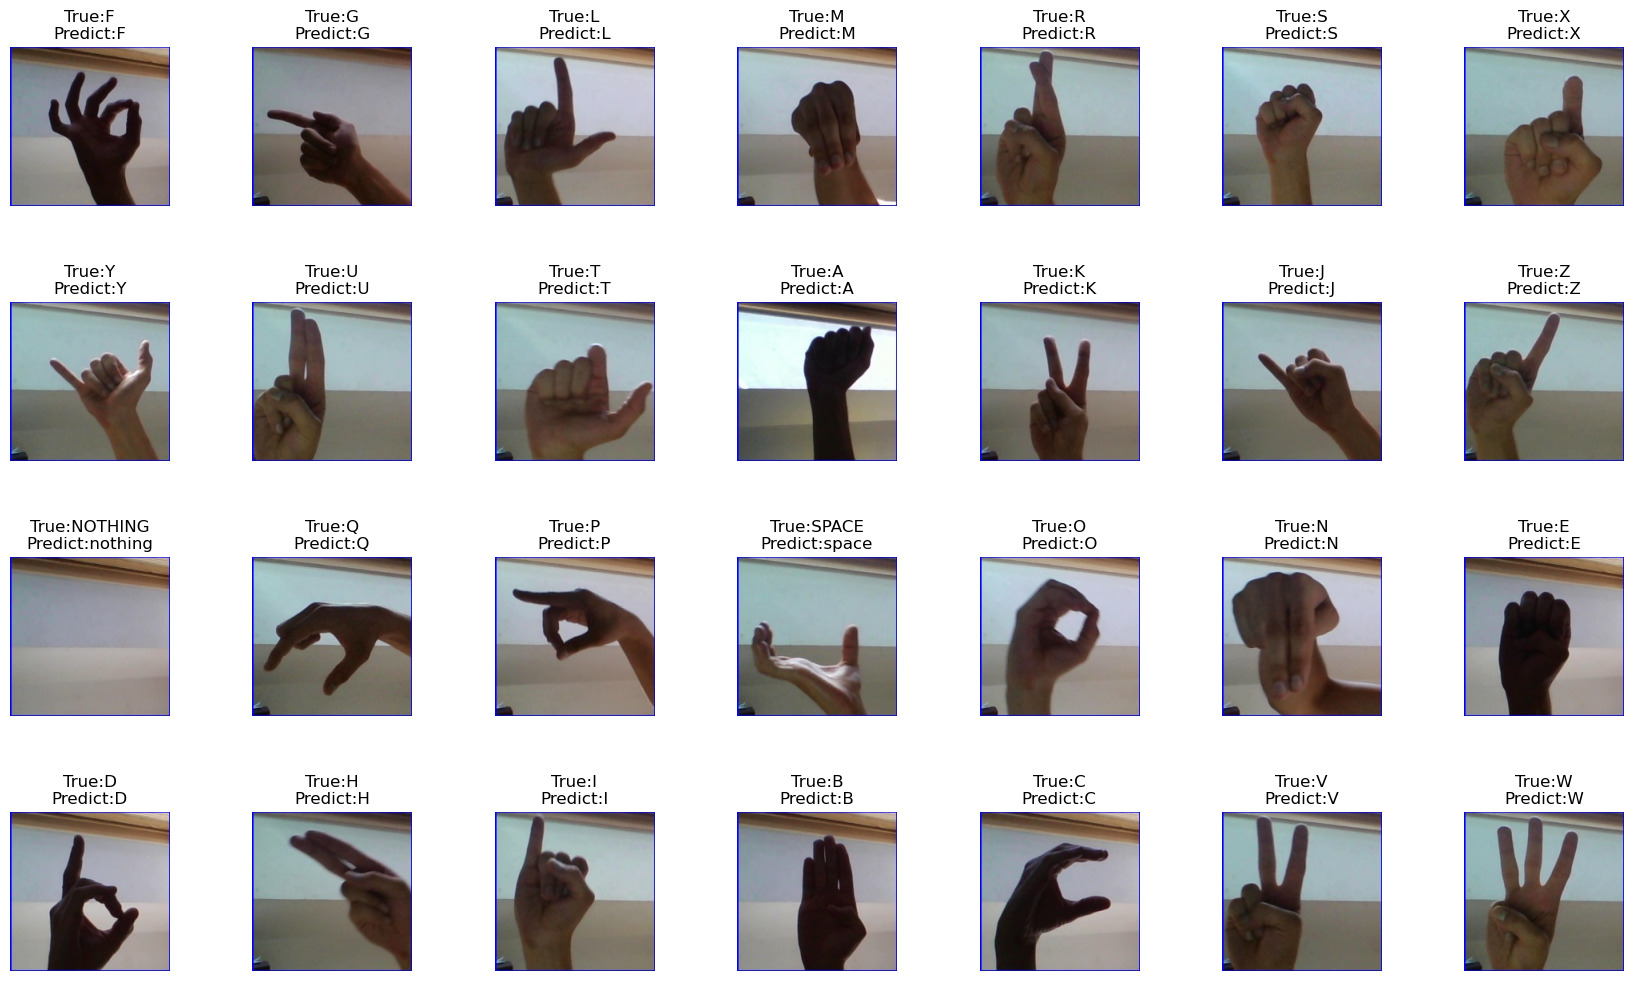

In [11]:
def evaluate_on_test_folder(model, test_dir, img_size, reverse_map, N=None):
    results = []
    
    all_files = [
        (os.path.splitext(f)[0].split("_")[0].strip().upper(), os.path.join(test_dir, f))
        for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    
    if N:
        all_files = all_files[:N]
    
    for true_label, img_path in all_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size)).astype("float32") / 255.0
        img_input = img.reshape(1, img_size, img_size, 1)
        
        pred = model.predict(img_input, verbose=0)
        pred_class = np.argmax(pred)
        pred_label = reverse_map[pred_class]
        
        results.append({
            "True Label": true_label,
            "Predicted Label": pred_label
        })
    
    # Display grid
    images_per_row = 7
    num_images = len(results)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(3 * images_per_row, 3 * num_rows))
    axes = axes.flatten()

    for i in range(len(axes)):
        ax = axes[i]
        if i < num_images:
            img_disp = cv2.imread(all_files[i][1])
            img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
            ax.set_title(f"True:{results[i]['True Label']}\nPredict:{results[i]['Predicted Label']}", fontsize=12)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # 👈 Adds gaps between columns (wspace) and rows (hspace)
    plt.show()

    return results


test_dir = "./data/asl_alphabet_test"  
results_cnn = evaluate_on_test_folder(model, test_dir, img_size=64, reverse_map=reverse_map)

In [12]:
# Compute accuracy
correct = sum(1 for r in results_cnn if r["True Label"] == r["Predicted Label"])
accuracy = correct / len(results_cnn) if results_cnn else 0
print(f"CNN 1 : Test accuracy: {accuracy:.4f}")

CNN 1 : Test accuracy: 0.9286


Confusion matrix

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Binary: 1 if prediction is correct, 0 if incorrect
y_true_binary = (y_pred == y_test).astype(int)
y_pred_binary = np.ones_like(y_true_binary)  # pretend all predictions are "True" to align with comparison

# Now confusion matrix for correct vs incorrect predictions
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Format as 2x2 table
cm_df = pd.DataFrame(cm_binary,
                     index=["Actually Incorrect", "Actually Correct"],
                     columns=["Predicted Incorrect", "Predicted Correct"])

print("Confusion Matrix:")
display(cm_df)

272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Confusion Matrix:


,Predicted Incorrect,Predicted Correct
Actually Incorrect,0,127
Actually Correct,0,8573


In [14]:
from sklearn.metrics import classification_report, f1_score

# Print precision, recall, f1-score for each class
print(classification_report(y_test, y_pred, digits=4))

# Optional: get macro/micro F1 score only
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Macro:    {f1_macro:.4f}")
print(f"F1 Micro:    {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

              precision    recall  f1-score   support

           0     0.9866    0.9966    0.9916       296
           1     0.9965    0.9863    0.9914       292
           2     1.0000    0.9968    0.9984       316
           3     0.9823    0.9964    0.9893       279
           4     0.9903    0.9745    0.9823       314
           5     1.0000    1.0000    1.0000       299
           6     1.0000    0.9898    0.9949       293
           7     0.9928    0.9928    0.9928       277
           8     1.0000    0.9934    0.9967       305
           9     0.9905    1.0000    0.9952       312
          10     0.9932    0.9898    0.9915       295
          11     1.0000    1.0000    1.0000       290
          12     0.9511    1.0000    0.9749       311
          13     1.0000    0.9598    0.9795       323
          14     0.9935    0.9682    0.9806       314
          15     0.9929    1.0000    0.9965       281
          16     1.0000    0.9892    0.9946       278
          17     0.9871    